In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    
print(device)

cpu


## MNIST / Lenet 300-100-10

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        8         7         6         0


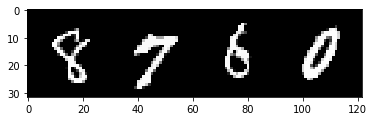

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [7]:
print(images.shape)
print(labels.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


In [14]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet_300_100(nn.Module):
    def __init__(self):
      super(LeNet_300_100, self).__init__()
      self.fc1 = nn.Linear(28*28, 300)
      self.fc2 = nn.Linear(300, 100)
      self.fc3 = nn.Linear(100, 10)


    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = LeNet_300_100()
net.to(device)

LeNet_300_100(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [11]:
def frame_potential(w):
  T_mod = w @ w.T
  squared_T_mod = T_mod @ T_mod
  return squared_T_mod.trace()

In [15]:
epochs = 10

training_loss = []
frame_potentials = {'fc1': [], 'fc2': [], 'fc3': []}

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # compute frame potentials
        fc1_weights = net.fc1.weight.cpu().detach().numpy()
        fc2_weights = net.fc2.weight.cpu().detach().numpy()
        fc3_weights = net.fc3.weight.cpu().detach().numpy()
        frame_potentials['fc1'].append(frame_potential(fc1_weights))
        frame_potentials['fc2'].append(frame_potential(fc2_weights))
        frame_potentials['fc3'].append(frame_potential(fc3_weights))

        # print statistics
        running_loss += loss.item()
        if i % 125 == 124:    # print every 2000 mini-batches -- 2000 / 1999
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 125))  # 2000
            training_loss.append(running_loss / 125)  # 2000
            running_loss = 0.0

print('Finished Training')

[1,   125] loss: 2.311
[1,   250] loss: 2.313
[1,   375] loss: 2.309
[1,   500] loss: 2.311
[1,   625] loss: 2.309
[1,   750] loss: 2.310
[1,   875] loss: 2.310
[2,   125] loss: 2.313
[2,   250] loss: 2.311
[2,   375] loss: 2.310
[2,   500] loss: 2.309
[2,   625] loss: 2.309
[2,   750] loss: 2.312
[2,   875] loss: 2.311
[3,   125] loss: 2.311
[3,   250] loss: 2.311
[3,   375] loss: 2.310
[3,   500] loss: 2.310
[3,   625] loss: 2.312
[3,   750] loss: 2.311
[3,   875] loss: 2.311
[4,   125] loss: 2.311
[4,   250] loss: 2.310
[4,   375] loss: 2.311
[4,   500] loss: 2.310
[4,   625] loss: 2.310
[4,   750] loss: 2.311
[4,   875] loss: 2.310
[5,   125] loss: 2.310
[5,   250] loss: 2.311
[5,   375] loss: 2.311
[5,   500] loss: 2.311
[5,   625] loss: 2.309
[5,   750] loss: 2.310
[5,   875] loss: 2.313
[6,   125] loss: 2.312
[6,   250] loss: 2.309
[6,   375] loss: 2.312
[6,   500] loss: 2.312
[6,   625] loss: 2.308
[6,   750] loss: 2.311
[6,   875] loss: 2.310
[7,   125] loss: 2.311
[7,   250] 

In [0]:
len(frame_potentials['fc3'])

9380

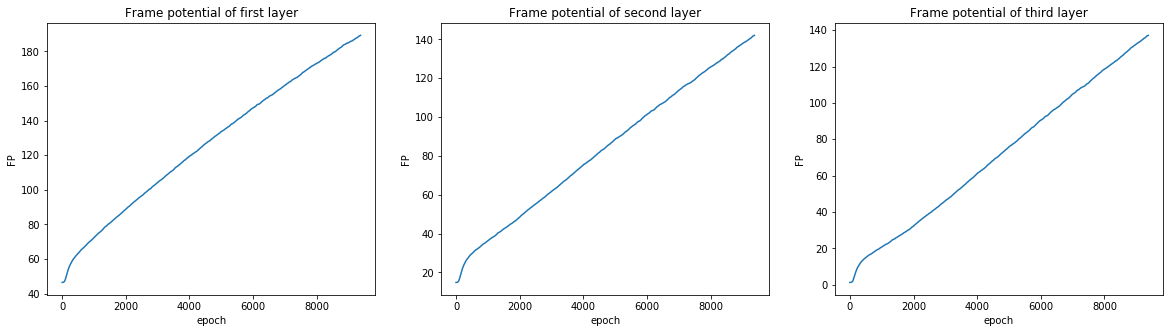

In [0]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, figsize=(20,5))
ax1.plot(frame_potentials['fc1'])
ax1.set_title('Frame potential of first layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['fc2'])
ax2.set_title('Frame potential of second layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(frame_potentials['fc3'])
ax3.set_title('Frame potential of third layer')
ax3.set(xlabel='epoch', ylabel='FP')


fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth: 
         7         2         1         0


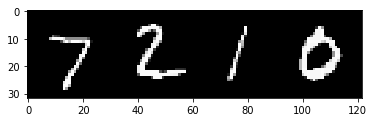

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%9s' % classes[predicted[j]]
                              for j in range(4)))

Predicted: 
         7         2         1         0


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 98 %
Accuracy of 1 : 97 %
Accuracy of 2 : 89 %
Accuracy of 3 : 96 %
Accuracy of 4 : 100 %
Accuracy of 5 : 92 %
Accuracy of 6 : 94 %
Accuracy of 7 : 96 %
Accuracy of 8 : 98 %
Accuracy of 9 : 97 %


## CIFAR10 / Conv-2

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


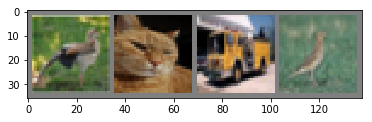

 bird   cat truck  bird


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
print(images.shape)

torch.Size([4, 3, 32, 32])


In [0]:
class Conv2(nn.Module):
    
    def __init__(self):
        super(Conv2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
  
    """
    def __init__(self):
        super(Conv2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    """
      
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

net = Conv2()
net.to(device)

Conv2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [0]:
net.fc1.weight.shape

torch.Size([256, 12544])

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)

In [0]:
epochs = 2

training_loss = []
frame_potentials = {'conv1': [], 'conv2': []}

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # compute frame potentials
        conv1_weights = net.conv1.weight.view(6, -1).cpu().detach().numpy()
        conv2_weights = net.conv2.weight.view(16, -1).cpu().detach().numpy()
        frame_potentials['conv1'].append(frame_potential(conv1_weights))
        frame_potentials['conv2'].append(frame_potential(conv2_weights))

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            training_loss.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.725
[1,  4000] loss: 1.395
[1,  6000] loss: 1.253
[1,  8000] loss: 1.196
[1, 10000] loss: 1.105
[1, 12000] loss: 1.062
[2,  2000] loss: 0.904
[2,  4000] loss: 0.887
[2,  6000] loss: 0.892
[2,  8000] loss: 0.881
[2, 10000] loss: 0.856
[2, 12000] loss: 0.840
Finished Training


[Text(0, 0.5, 'FP'), Text(0.5, 0, 'epoch')]

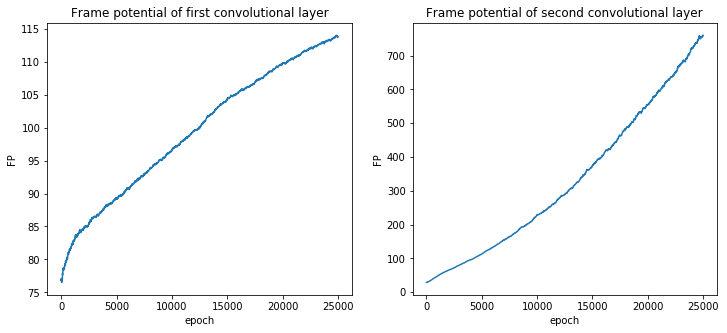

In [0]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, figsize=(12,5))
ax1.plot(frame_potentials['conv1'])
ax1.set_title('Frame potential of first convolutional layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['conv2'])
ax2.set_title('Frame potential of second convolutional layer')
ax2.set(xlabel='epoch', ylabel='FP')

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 69 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 65 %
Accuracy of  bird : 51 %
Accuracy of   cat : 46 %
Accuracy of  deer : 53 %
Accuracy of   dog : 20 %
Accuracy of  frog : 49 %
Accuracy of horse : 59 %
Accuracy of  ship : 79 %
Accuracy of truck : 57 %
